# Classification( of 14 Thoractic Disease ) using CNN

***


<u>**Contents**</u>

1. Datasets
2. Preprocessing( Labels, Images )
3. Image Generator and Loader
4. Model
5. Training
6. Evaluation

***

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set()


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14882327398522813363
]


## 1. Datasets

***

[[**Source@**](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community)]


This NIH Chest X-ray8 Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning. [[More@](https://arxiv.org/abs/1705.02315)]

- Subset of this Dataset was used for [[Exploration.ipynb]()] of X-ray images and some of the [[Challenges.ipynb]()] within datasets.
- Full dataset was used with the split of (70|20|10) respectively and list of labels for the images from [here](https://github.com/arnoweng/CheXNet/tree/master/ChestX-ray14/labels).

### Instruction

- [[**Download@**](https://nihcc.app.box.com/v/ChestXray-NIHCC)] | `python Utils/download.py` to download Images($\approx 45 GB$)

- Create `/Datasets/images/`, Extract the compressed files inside images directory.
- Directory tree:

```bash
./Datasets/
    - images/
        - images_001/<images-here>
        - images_002/<images-here>
        - images_003/<images-here>
        - images_004/<images-here>
        - images_005/<images-here>
        - images_006/<images-here>
        - images_007/<images-here>
        - images_008/<images-here>
        - images_009/<images-here>
        - images_010/<images-here>
        - images_011/<images-here>
        - images_012/<images-here>
    - preprocessing.py

```

### Dataset Info

**Boundary box dataset provided by NIH (not used for our task)** Relevant for localization of anomalies.

In [2]:
bbox_df = pd.read_csv('./Datasets/BBox_List_2017.csv')
print('Shape :',bbox_df.shape)
bbox_df.head(3)

Shape : (984, 9)


,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN


**Main dataset information with disease information (used in this notebook)**

There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:
- Atelectasis
- Consolidation
- Infiltration
- Pneumothorax
- Edema
- Emphysema
- Fibrosis
- Effusion
- Pneumonia
- Pleural_thickening
- Cardiomegaly
- Nodule Mass
- Hernia

In [3]:
full_df = pd.read_csv('./Datasets/Data_Entry_2017.csv')
print(f'Shape : {full_df.shape} \n')
full_df.head(3)

Shape : (112120, 12) 



,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN


## 2. Preprocessing
***

### 2.1 Data Preprocessing

#### Initial Dataframe

In [4]:
full_df = pd.read_csv('./Datasets/Data_Entry_2017.csv')
print(f'Shape : {full_df.shape} \n')

full_df = full_df.drop(columns=['Follow-up #','OriginalImage[Width', 'Height]','OriginalImagePixelSpacing[x','y]','Unnamed: 11'])

full_df.head(3)

Shape : (112120, 12) 



,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender,View Position
0,00000001_000.png,Cardiomegaly,1,58,M,PA
1,00000001_001.png,Cardiomegaly|Emphysema,1,58,M,PA
2,00000001_002.png,Cardiomegaly|Effusion,1,58,M,PA


#### Unique labels counts in `Finding Labels` and Distribution (Barplot)

In [5]:
# Number of unique labels in column Finding Labels
labels_col = full_df['Finding Labels']

# No. of unique labels
n_uniq_labels = labels_col.nunique()
print('Number of unique labels:',n_uniq_labels)

# Frequency (counts per label)
count_uniq_label = labels_col.value_counts()

# Unique Labels to Dataframe
df_count_uniq_label = count_uniq_label.to_frame()
df_count_uniq_label.head(20)

Number of unique labels: 836


,Finding Labels
No Finding,60361
Infiltration,9547
Atelectasis,4215
Effusion,3955
Nodule,2705
Pneumothorax,2194
Mass,2139
Effusion|Infiltration,1603
Atelectasis|Infiltration,1350
Consolidation,1310


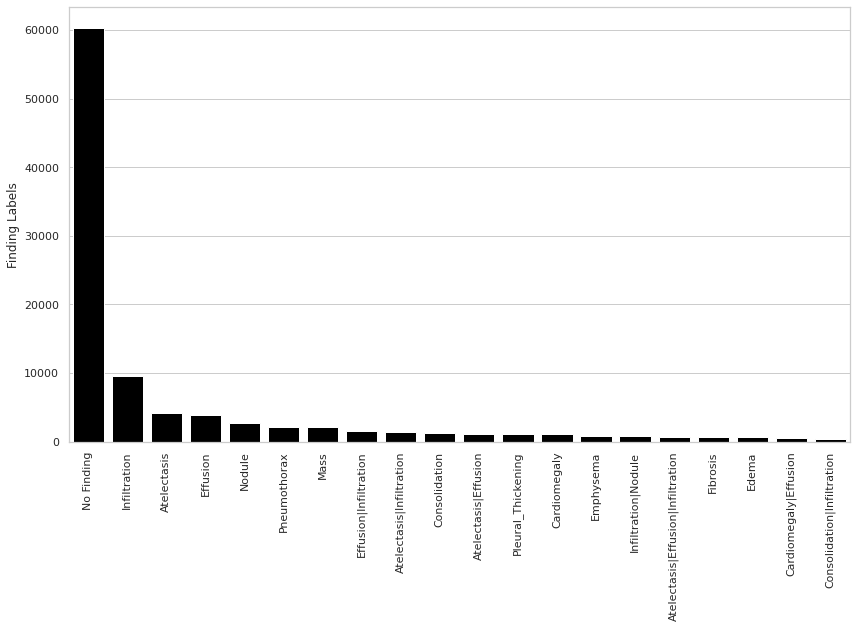

In [7]:
# Plot
uniq_labels = df_count_uniq_label.index[:20]
count_uniq_labels = df_count_uniq_label[:20]

fig = plt.gcf()
fig.set_size_inches(14, 8)

sns.set_style("whitegrid")
sns.barplot(x=uniq_labels, y="Finding Labels", data=count_uniq_labels, color = "black"), plt.xticks(rotation = 90);

#### One hot encoding of diseases to Dataframe

In [10]:
from itertools import chain

# labels = ['Atelectasis'
#           , 'Consolidation'
#           , 'Infiltration'
#           , 'Pneumothorax'
#           , 'Edema'
#           , 'Emphysema'
#           , 'Fibrosis'
#           , 'Effusion'
#           , 'Pneumonia'
#           , 'Pleural_Thickening'
#           , 'Cardiomegaly'
#           , 'Nodule'
#           , 'Mass'
#           , 'Hernia']

# for label in labels:
#     full_df[label] = full_df['Finding Labels'].map(lambda result: 1.0 if label in result else 0)
    

full_df['Finding Labels'] = full_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

labels = np.unique(list(chain(*full_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

labels = [x for x in labels if len(x)>0]
print(labels)

# print('All Labels ({}): {}'.format(len(labels), labels))

for clean_label in labels:
    if len(clean_label)>1: # leave out empty labels
        full_df[clean_label] = full_df['Finding Labels'].map(lambda finding: 1.0 if clean_label in finding else 0)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [11]:
full_df.head(3)

,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,1,58,M,PA,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,58,M,PA,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,1,58,M,PA,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Distribution of clean labels ( without Normal cases)

In [12]:
# Excluding No-Findings number of cases present for each of 14 classes.
# Sorted value_count for clean labels

clean_labels = full_df[labels].sum().sort_values(ascending= False)

df_clean_labels_count = clean_labels.to_frame()
df_clean_labels_count.head(14)

,0
Infiltration,19894.0
Effusion,13317.0
Atelectasis,11559.0
Nodule,6331.0
Mass,5782.0
Pneumothorax,5302.0
Consolidation,4667.0
Pleural_Thickening,3385.0
Cardiomegaly,2776.0
Emphysema,2516.0


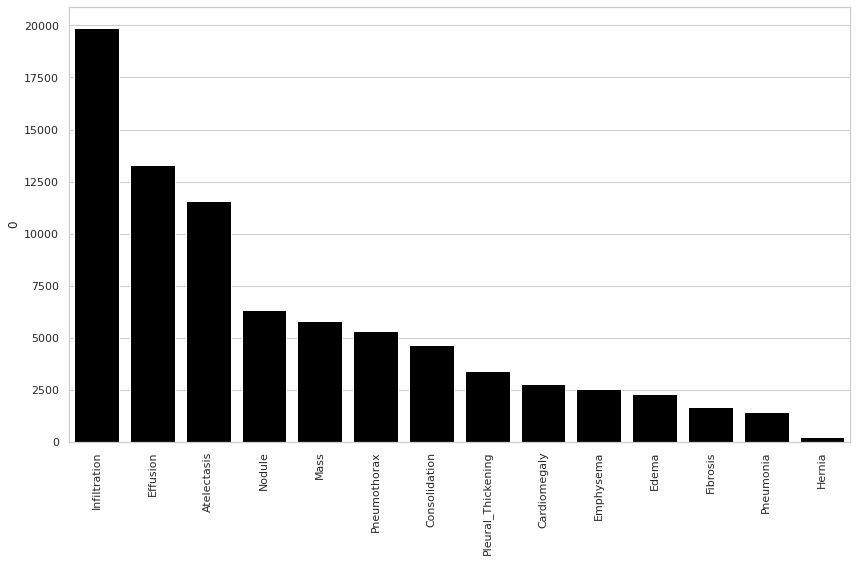

In [13]:
# Plot
clean_labels_idx = df_clean_labels_count.index[::]
clean_labels = df_clean_labels_count[::]

fig = plt.gcf()
fig.set_size_inches(14, 8)

sns.set_style("whitegrid")
sns.barplot(x = clean_labels_idx, y=0, data = clean_labels[::], color = "black"), plt.xticks(rotation = 90);

#### Ground truth vector to Dataframe

In [14]:
# create vector as ground-truth, will use as actuals to compare against our predictions later
full_df['target_vector'] = full_df.apply(lambda target: [target[labels].values], 1).map(lambda target: target[0])
full_df.head(5)

,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,Consolidation,Edema,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,target_vector
0,00000001_000.png,Cardiomegaly,1,58,M,PA,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,58,M,PA,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,1,58,M,PA,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,00000002_000.png,,2,81,M,PA,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,Hernia,3,81,F,PA,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


#### Relative path of images to Dataframe

In [15]:
# The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.
from glob import glob

# List of full image paths
my_glob = glob('./Datasets/images/*/*/*.png')

# img_paths to dataframe
img_paths = {os.path.basename(x): x for x in my_glob}
full_df['img_paths'] = full_df['Image Index'].map(img_paths.get)


print(f'Number of Images:  {len(my_glob)}\n')
full_df.head(5)

Number of Images:  112120



,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,Consolidation,Edema,...,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,target_vector,img_paths
0,00000001_000.png,Cardiomegaly,1,58,M,PA,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./Datasets/images/images_001/images/00000001_0...
1,00000001_001.png,Cardiomegaly|Emphysema,1,58,M,PA,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",./Datasets/images/images_001/images/00000001_0...
2,00000001_002.png,Cardiomegaly|Effusion,1,58,M,PA,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",./Datasets/images/images_001/images/00000001_0...
3,00000002_000.png,,2,81,M,PA,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./Datasets/images/images_001/images/00000002_0...
4,00000003_000.png,Hernia,3,81,F,PA,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",./Datasets/images/images_001/images/00000003_0...


#### Clean dataframe: `xray_df` : for Loader and Generator

In [16]:
xray_df = full_df.drop(columns=['Finding Labels','Patient Age', 'Patient Gender','View Position'])
xray_df.head(3)

,Image Index,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,target_vector,img_paths
0,00000001_000.png,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./Datasets/images/images_001/images/00000001_0...
1,00000001_001.png,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",./Datasets/images/images_001/images/00000001_0...
2,00000001_002.png,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",./Datasets/images/images_001/images/00000001_0...


#### Unique Patient ID

In [17]:
print('------------------------------------------------------------')
print('Total Patient IDs :', xray_df['Patient ID'].count())
print('Unique Patient IDs :', xray_df['Patient ID'].value_counts().shape[0])
print('------------------------------------------------------------')

------------------------------------------------------------
Total Patient IDs : 112120
Unique Patient IDs : 30805
------------------------------------------------------------


### 2.2 Image Preprocessing 

-  Resize images to (128x128)
-  Increase of exposure using Contrast Limited Adaptive Histogram Equalization (CLAHE).


**Before: (1028 x 1024)**

![](./assets/before.jpg)

**After: (128 x 128)**

![](./assets/after.jpg)

**Remark:** *Both image above rescaled to (250 x 250) for visualization*

**Run Once ( before Runtime )**

Since the kernel will be busy running this cell for a while *(CPU Time : 2.5 hours on [Intel i7-9750H (12) @ 2.600GHz])*, it is recommended to use terminal `python Datasets/preprocessing.py` instead. The cell below is in markdown


```python
%%writefile ./Datasets/preprocessing.py
#-------------------------------------------------------------------------------------------------------------
# Resize and CLAHE to Images | (CPU Time : 2.5 hours on [Intel i7-9750H (12) @ 2.600GHz])  
#-------------------------------------------------------------------------------------------------------------

from glob import glob
from skimage import exposure, transform

img_shape = (128,128)

# List of paths 
my_glob = glob('./Datasets/images/images*/*.png')

# Dictionary with key = img_name and value = 'full path'
img_paths = {os.path.basename(x): x for x in my_glob}
# print(img_paths['00025789_001.png'])

# Create new directories to contain processed samples
path_list = os.listdir('./Datasets/images/')
for dirs in path_list:
    os.makedirs(f'./Datasets/xray_preprocessed/{dirs}', exist_ok=True)

#---------------------------------------Image Processing ------------------------------------------------------

i=0
for img_path in my_glob :
    i += 1
    
    # print no. of sample after every processed 1000
    if  i % max(1, int(len(my_glob)/1000))==0: print(i, '/', len(my_glob))
        
    # save processed images to xray_preprocessed
    new_path = img_path.replace('images', 'xray_preprocessed')
    img = plt.imread(img_path)
    
    # Increase Exposure with CLAHE
    img = exposure.equalize_adapthist(img, clip_limit=0.05)
    
    # Resize Image to img_shape
    img = transform.resize(img, img_shape, anti_aliasing=True)
    plt.imsave(fname=new_path, arr=img, cmap='gray')
    
print('>>> -------------------------- Processing Complete -------------------------- <<< ')
#-------------------------------------------------------------------------------------------------------------
```

### Image Samples Info

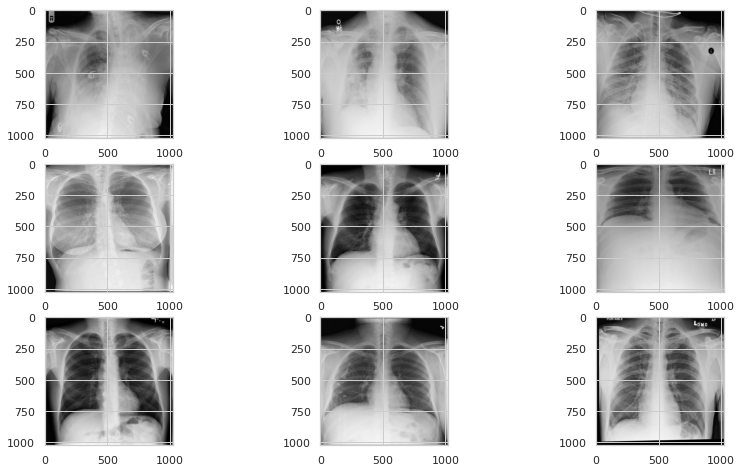

In [18]:
# Dataframe : numpy values from Image column
path_col = xray_df['img_paths']

images = path_col.values
rand_img = [np.random.choice(images) for i in range(9)]

# Plot 9 random images

fig = plt.gcf()
fig.set_size_inches(14, 8)

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(rand_img[i])
    plt.imshow(img, cmap='gray')

#### Pixel distribution

./Datasets/images/images_001/images/00000011_005.png
Img. Dimension:  (1024, 1024)
Max, Min Pixel values (1.0, 0.0)
Mean, SD of Pixel values (0.4833869, 0.2577094)


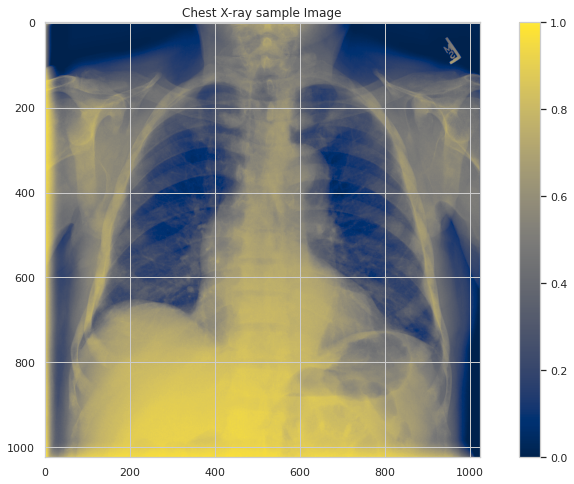

In [19]:
sample_img = plt.imread(path_col[30])
print(path_col[33])

fig = plt.gcf()
fig.set_size_inches(14, 8)

plt.title('Chest X-ray sample Image')
plt.imshow(sample_img, cmap='cividis')
plt.colorbar()

print('Img. Dimension: ', sample_img.shape)
print('Max, Min Pixel values',( sample_img.max(), sample_img.min()))
print('Mean, SD of Pixel values', (sample_img.mean(), sample_img.std()))

Text(0, 0.5, 'no. of pixels in image')

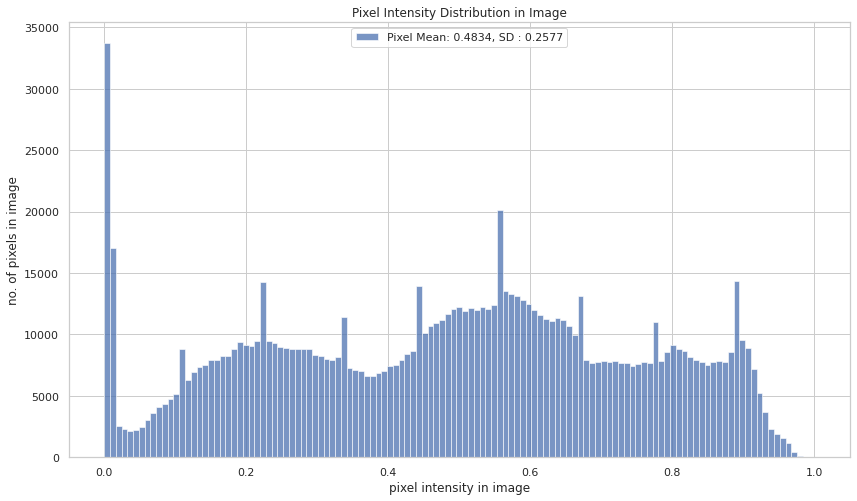

In [20]:
# Histogram of Pixel distribution

fig = plt.gcf()
fig.set_size_inches(14, 8)

sns.histplot(
    sample_img.ravel()
    , label = f'Pixel Mean: {np.mean(sample_img):.4f}, SD : {np.std(sample_img):.4f}'
    , kde=False )

plt.legend(loc='upper center')
plt.title('Pixel Intensity Distribution in Image')
plt.xlabel('pixel intensity in image')
plt.ylabel('no. of pixels in image')

## 3. Image Generator and Loader
***

### `xray_df` : Processed DataFrame

In [21]:
xray_df.head(3)

,Image Index,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,target_vector,img_paths
0,00000001_000.png,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./Datasets/images/images_001/images/00000001_0...
1,00000001_001.png,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",./Datasets/images/images_001/images/00000001_0...
2,00000001_002.png,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",./Datasets/images/images_001/images/00000001_0...


In [22]:
# Null check and Datatype
print('------------------------------------------------------------')
xray_df.info()
print('------------------------------------------------------------')

------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Image Index         112120 non-null  object 
 1   Patient ID          112120 non-null  int64  
 2   Atelectasis         112120 non-null  float64
 3   Cardiomegaly        112120 non-null  float64
 4   Consolidation       112120 non-null  float64
 5   Edema               112120 non-null  float64
 6   Effusion            112120 non-null  float64
 7   Emphysema           112120 non-null  float64
 8   Fibrosis            112120 non-null  float64
 9   Hernia              112120 non-null  float64
 10  Infiltration        112120 non-null  float64
 11  Mass                112120 non-null  float64
 12  Nodule              112120 non-null  float64
 13  Pleural_Thickening  112120 non-null  float64
 14  Pneumonia           112

```python
partition= {}

partition['train'] = train_set['img_paths'].to_list()
partition['dev'] = dev_set['img_paths'].to_list()
partition['test'] = test_set['img_paths'].to_list()

print(partition['dev'][0])

val_data = pd.read_csv('./Datasets/labels/val_list.txt', header=None, index_col=None)[0].str.split(' ', 1)
print(val_data[0])

val_labels = np.vstack(val_data.apply(lambda x: max(x[1].split())).values).astype(np.int8)[:10]
print(val_labels)

train_images = val_data.apply(lambda x: './Datasets/images_preprocessed/' + x[0]).values[:20]
print(train_images)
```

### Image paths, Target Vectors, Labels

In [49]:
# base_dir = os.path.dirname(xray_df['img_paths'].values[0])
# print(f'Directories Dict eg (values[0]):{base_dir}')
print('------------------------------------------------------------')

filenames = xray_df['img_paths'].values
print(f'Filenames : \n\n{filenames}\n\nDtype: {type(filenames)}')
print('------------------------------------------------------------')

classes = np.stack(xray_df['target_vector'].values)
print(f'Target Vector (stacked) :\n\n{classes}\n\nDtype: {type(classes)}')
print('------------------------------------------------------------')

labels = xray_df.columns[2:-2]
print(f'Label Columns :\n\n{labels} :\n\nDtype: {type(labels)}')
print('------------------------------------------------------------')

------------------------------------------------------------
Filenames : 

['./Datasets/images/images_001/images/00000001_000.png'
 './Datasets/images/images_001/images/00000001_001.png'
 './Datasets/images/images_001/images/00000001_002.png' ...
 './Datasets/images/images_012/images/00030803_000.png'
 './Datasets/images/images_012/images/00030804_000.png'
 './Datasets/images/images_012/images/00030805_000.png']

Dtype: <class 'numpy.ndarray'>
------------------------------------------------------------
Target Vector (stacked) :

[[0.0 1.0 0.0 ... 0.0 0.0 0.0]
 [0.0 1.0 0.0 ... 0.0 0.0 0.0]
 [0.0 1.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]]

Dtype: <class 'numpy.ndarray'>
------------------------------------------------------------
Label Columns :

Index(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pl

### Train-Dev-Test split (70%,10%,20%) : Dataframe Split

In [24]:
from sklearn.model_selection import train_test_split

train_and_dev_df, test_df = train_test_split(xray_df, test_size = 0.2, random_state = 111)
train_df, dev_df = train_test_split(train_and_dev_df, test_size = 0.16, random_state = 111)

print('------------------------------------------------------------')
print(f'Shape : Train-Set {train_df.shape}')
print(f'Shape : Dev-Set {dev_df.shape}')
print(f'Shape : Test-Set {test_df.shape}')
print('------------------------------------------------------------')

------------------------------------------------------------
Shape : Train-Set (75344, 18)
Shape : Dev-Set (14352, 18)
Shape : Test-Set (22424, 18)
------------------------------------------------------------


### Image Generator

In [25]:
from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator( featurewise_center=False
                             , samplewise_center=True
                             , featurewise_std_normalization=False
                             , samplewise_std_normalization=True
                             , zca_whitening=False
                             , zca_epsilon=1e-06
                             , rotation_range=5
                             , width_shift_range=0.1
                             , height_shift_range=0.05
                             , brightness_range=None
                             , shear_range=0.1
                             , zoom_range=0.15
                             , channel_shift_range=0.0
                             , fill_mode="reflect"
                             , cval=0.0
                             , horizontal_flip=True
                             , vertical_flip=False
                             , rescale=None
                             , preprocessing_function=None
                             , data_format=None
                             , validation_split=0.0
                             , dtype=None)

test_datagen=ImageDataGenerator(rescale=1./255.)

In [26]:
# ---------------------------------------------------------------
# train_label = np.stack(train_df['target_vector'].values)
# dev_label = np.stack(dev_df['target_vector'].values)
# test_label = np.stack(test_df['target_vector'].values)
# ---------------------------------------------------------------
# def flow_from_dataframe(img_data_gen, df, path_col, y_col, **dflow_args):
#     base_dir = os.path.dirname(df[path_col].values[0])
#     print('## Ignore next message from keras, values are replaced anyways')
#     df_gen = img_data_gen.flow_from_directory(base_dir, 
#                                      class_mode = 'sparse',
#                                     **dflow_args)
#     df_gen.filenames = in_df[path_col].values
#     df_gen.classes = np.stack(in_df[y_col].values)
#     df_gen.samples = in_df.shape[0]
#     df_gen.n = in_df.shape[0]
#     df_gen._set_index_array()
#     df_gen.directory = '' # since we have the full path
#     print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
#     return df_gen
# ---------------------------------------------------------------

### Image loader from Dataframe

In [27]:
train_generator = data_gen.flow_from_dataframe(dataframe=train_df,
                                            directory=None,
                                            x_col="img_paths",
                                            y_col=labels,
                                            weight_col=None,
                                            target_size=(256, 256),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="raw",
                                            batch_size=32,
                                            shuffle=True,
                                            seed=111,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset=None,
                                            interpolation="nearest",
                                            validate_filenames=True,)

# train_generator.y_col = np.stack(train_df['target_vector'].values)

dev_generator = data_gen.flow_from_dataframe(dataframe=dev_df,
                                            directory=None,
                                            x_col="img_paths",
                                            y_col=labels,
                                            weight_col=None,
                                            target_size=(256, 256),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="raw",
                                            batch_size=32,
                                            shuffle=True,
                                            seed=111,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset=None,
                                            interpolation="nearest",
                                            validate_filenames=True,)

# dev_generator.y_col = np.stack(train_df['target_vector'].values)

test_generator = test_datagen.flow_from_dataframe( dataframe=test_df,
                                            directory=None,
                                            x_col="img_paths",
                                            y_col=None,
                                            batch_size=32,
                                            color_mode="rgb",
                                            seed=111,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(256,256))

Found 75344 validated image filenames.
Found 14352 validated image filenames.
Found 22424 validated image filenames.


  0%|          | 0/8 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 75%|███████▌  | 6/8 [00:00<00:00, 52.87it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 8/8 [00:00<00:00, 47.

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


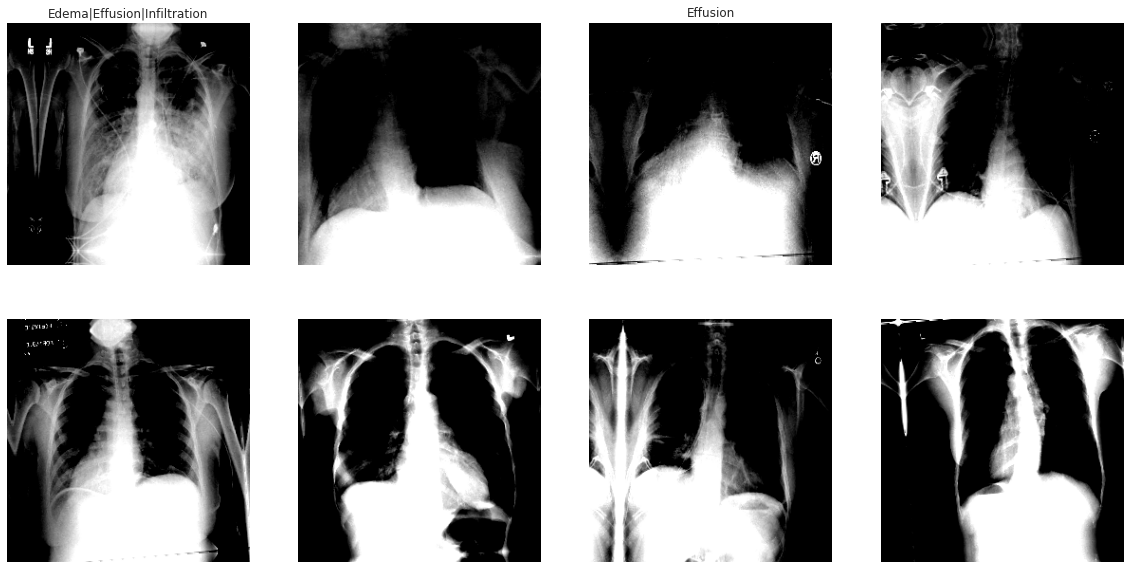

In [32]:
from tqdm import tqdm

def get_label(y):
    """
    Returns the appended label list of the given set. 
    
    y(list) the one hot vector list containing the label encoding. 
    """
    ret_labels = []
    i = 0
    for idx in y:
        if idx:
            ret_labels.append(labels[i])
        i += 1
    if not ret_labels:
        return ''
    else:
        return '|'.join(ret_labels)
    
t_x, t_y = train_generator.__getitem__(0)

fig=plt.figure(figsize=(20, 10))
columns = 4; rows = 2 

for i in tqdm(range(1, columns*rows +1)):
    fig.add_subplot(rows, columns, i)
    plt.imshow(t_x[i-1], cmap = 'bone')
    plt.title(get_label(t_y[i-1]))
    plt.axis(False)
    fig.add_subplot
    
print(type(t_x))
print(type(t_y))

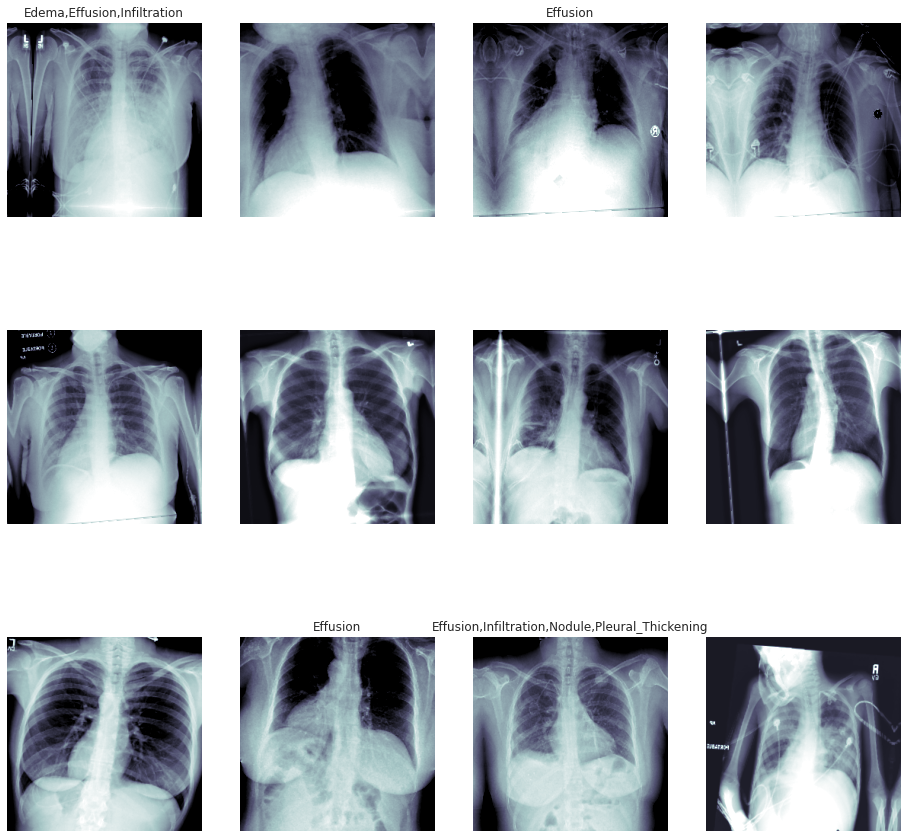

In [33]:
fig, m_axs = plt.subplots(3, 4, figsize = (16, 16))

for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(','.join([n_class for n_class, n_score in zip(labels, c_y) if n_score>0.5]))
    c_ax.axis('off')

## Problem of Class-Imbalance

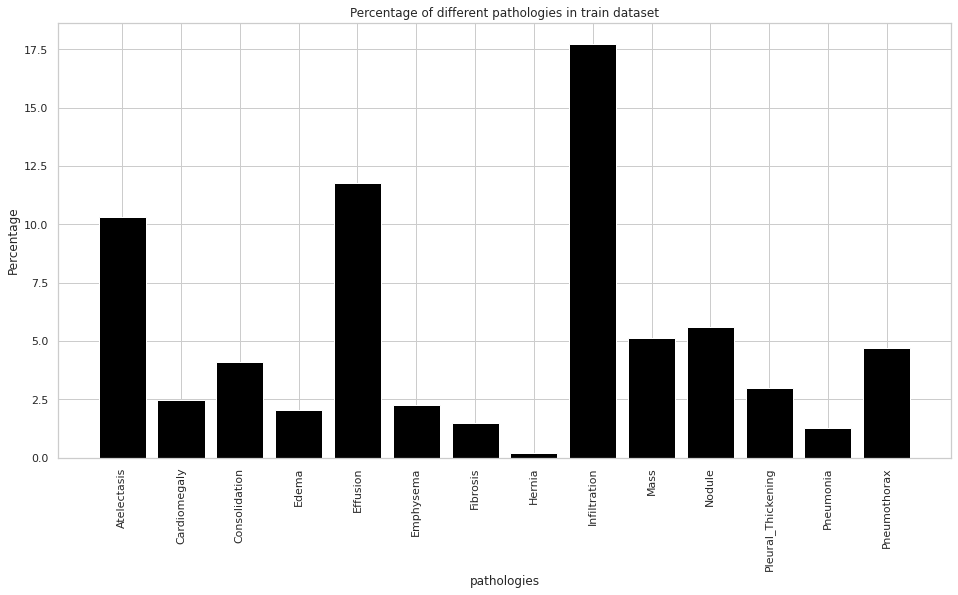

In [57]:
fig = plt.gcf()
fig.set_size_inches(16, 8)
sns.set_theme(style="whitegrid")

plt.xticks(rotation = 90)
plt.bar(labels, train_generator.labels.sum(axis = 0)/train_generator.n * 100, color='black')
plt.title('Percentage of different pathologies in train dataset')
plt.xlabel('pathologies')
plt.ylabel('Percentage')
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss. 

### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

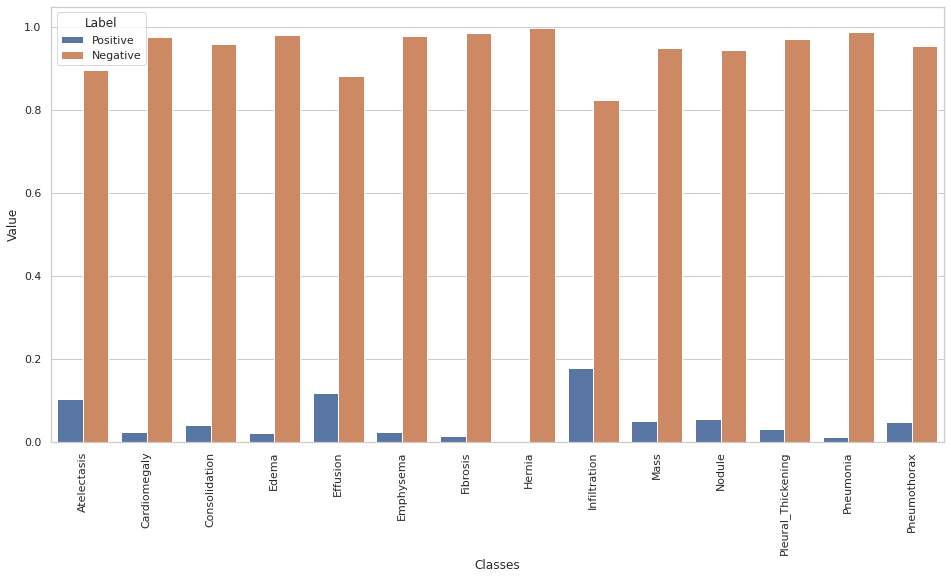

In [73]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies


# calulating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

data = pd.DataFrame({"Classes": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Classes": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)

fig = plt.gcf()
fig.set_size_inches(16, 8)
sns.set_theme(style="whitegrid")

plt.xticks(rotation=90)
f = sns.barplot(x="Classes", y="Value", hue="Label" ,data=data)

------------------------------------------------------------
Positive Weights : 

[0.89672701 0.97518051 0.95886866 0.97948078 0.88222022 0.97748991
 0.98506849 0.9980224  0.82252071 0.94870195 0.94410968 0.9698848
 0.98744426 0.95285623]


Negative Weights : 

[0.10327299 0.02481949 0.04113134 0.02051922 0.11777978 0.02251009
 0.01493151 0.0019776  0.17747929 0.05129805 0.05589032 0.0301152
 0.01255574 0.04714377]
------------------------------------------------------------


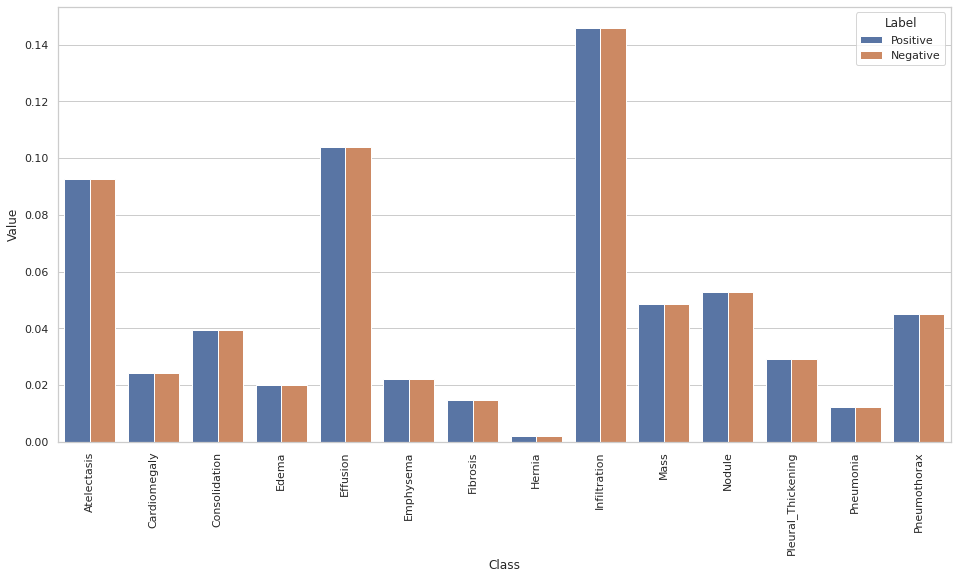

In [74]:
# positive and negative weights

pos_weights = freq_neg
neg_weights = freq_pos

pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
print('------------------------------------------------------------')
print(f'Positive Weights : \n\n{pos_weights}')
print(f'\n\nNegative Weights : \n\n{neg_weights}')
print('------------------------------------------------------------')

# Plot
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}  for l,v in enumerate(neg_contribution)], ignore_index=True)

fig = plt.gcf()
fig.set_size_inches(16, 8)
sns.set_theme(style="whitegrid")

plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

### Weighted Loss Instead of Binary Cross-Entropy Loss

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. 
After computing the weights, the final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [75]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss

    return weighted_loss

## Model

***

#### Choose The model ( Custom | Densenet 121(Percent to train(0-1) ))

**Options :**

- `custom` | `densenet121`

In [77]:
import tensorflow as tf
from Model.Xnet import Xnet

model = Xnet(model2load='custom',
                    percent2retrain=1,
                    image_dimensions=(256,256,3),
                    n_classes=len(labels)).get_model()
model.summary()

# may need to install pydot and grapviz for plot_model

# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
# )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)     

In [78]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]

# [print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 256, 256, 3) <dtype: 'float32'>
(None, 14) <dtype: 'float32'>


[None]

## Training
***

In [79]:
import time
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LambdaCallback

### Parameters

In [88]:
# Parameters
test_trained_model     = False
load_previous_weights  = False

# -----------------------------------------------
# samples_to_train  = 3000 #max: 78468
# samples_to_val    = 250  #max: 11219
# samples_to_test   = 2000 #max: 22433

# #decrease resource usage:
idle_time_on_batch = 0.1
idle_time_on_epoch = 20
# -----------------------------------------------
train_steps = len(train_generator)
epochs = 1
batch_size = 32
image_shape = (256, 256, 3)
model_learn_rate = 0.01
model_architecture = 'custom'

### Train Model

In [ ]:
if not test_trained_model:
    
    # Recall the model
    print('---------------- Creating Model ----------------')
    model = Xnet(model2load=model_architecture,
                        percent2retrain=0.6,
                        image_dimensions=image_shape,
                        n_classes=14).get_model()
    
    # Load previous Model weights
    print('---------------- Training Model ----------------')
    if load_previous_weights == True:
        print('Loading Model Weights')
        model.load_weights("model_weights.hdf5")
        
    print('---------------- Optimization Init ----------------')
    # Gradient Optimization
    optimizer = Adam(lr=model_learn_rate,
                     beta_1=0.9,
                     beta_2=0.999,
                     epsilon=1e-08,
                     decay=0.0,
                     amsgrad=False)
    
    print('---------------- Compiling Model ----------------')
    model.compile(optimizer=optimizer
                  , loss=get_weighted_loss(pos_weights, neg_weights)
                  , metrics=['acc'])
    
    # Learning rate Decay
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                                patience=5,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00000001)
    
    # Early Stopping (In case model is starting to overfit )
    early_stop = EarlyStopping(monitor="val_loss",
                               mode="min",
                               patience=12)
    
    # Save model Checkpoint
    checkpoint = ModelCheckpoint('model_weights.hdf5',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',
                                 save_weights_only=True)
    
    # sleep after each batch and epoch (prevent laptop from melting) (sleeps for x sec)(remove for faster training)
#     idle = LambdaCallback(on_epoch_end=lambda batch
#                           , logs: time.sleep(idle_time_on_epoch)
#                           , on_batch_end=lambda batch
#                           , logs: time.sleep(idle_time_on_batch))
    
    # save model to json file
    with open("model.json", "w") as json_model:
        json_model.write(model.to_json())
        
    # model.summary()
    
    print('---------------- Training Model ----------------')
    history = model.fit(train_generator,
                        steps_per_epoch=train_steps,
                        epochs=epochs,
                        validation_data=dev_generator,
                        max_queue_size=15,
                        workers=8,
                        callbacks=[learning_rate_reduction, early_stop, checkpoint],
                    )

    
    print('---------------- Loss and Accuracy ----------------')
    fig, ax = plt.subplots(2, 1, figsize=(6, 6))
    ax[0].plot(history.history['loss'], label="TrainLoss")
    ax[0].plot(history.history['val_loss'], label="ValLoss")
    ax[0].legend(loc='best', shadow=True)
    ax[1].plot(history.history['acc'], label="TrainAcc")
    ax[1].plot(history.history['val_acc'], label="ValAcc")
    ax[1].legend(loc='best', shadow=True)
    plt.show()



else: # if use_trained_model:
    
    print('---------------- Loading Model ----------------')
    from keras.models import model_from_json
    
    with open('model.json', 'r') as json_model:
        model = model_from_json(json_model.read())
        
    print('----------------Loading Weights----------------')
    model.load_weights("model_weights.hdf5")
    
    print('---------------- Optimization Init ----------------')
    optimizer = Adam(lr=model_learn_rate
                     , beta_1=0.9
                     , beta_2=0.999
                     , epsilon=1e-08
                     , decay=0.0
                     , amsgrad=False)
    
    model.compile(optimizer=optimizer
                  , loss=get_weighted_loss(pos_weights, neg_weights)
                  , metrics=['acc'])

---------------- Creating Model ----------------
---------------- Training Model ----------------
---------------- Optimization Init ----------------
---------------- Compiling Model ----------------
---------------- Training Model ----------------
  61/2355 [..............................] - ETA: 3:20:51 - loss: 9.2974 - acc: 0.2070

## Evaluation
***

In [ ]:
print('---------------- Model Evaluation ----------------')

test_score = model.evaluate(test_data, verbose=2)
print('\nModel Accuracy: ', test_score[1])

print('\nParameters used:',
    '\ntrain_samples:   ',samples_to_train,
    '\nepochs:          ',epochs,
    '\nbatch_size:      ',batch_size,
    '\ninit_learn_rate: ',model_learn_rate)


print('---------------- Confusion Matrix ----------------')
predict_out = model.predict(test_data, verbose=2)
test_predict = (predict_out > 0.5).astype(np.int8)

conf_matrix = confusion_matrix(y_true=data_loader.test_data[1], y_pred=test_predict)

sns.heatmap(conf_matrix, annot=True, cmap='Blues', cbar=False, square=True, xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

***